In [1]:
import jax
from jax import random
from jax import numpy as jnp
import json
import matplotlib.pyplot as plt
import mediapy
import numpy as np
import optax
import os
import pickle
from PIL import Image

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices("GPU")

if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

2024-09-16 13:11:40.114036: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-09-16 13:11:40.680613: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


In [2]:
import sys

sys.path.append("./")
sys.path.append("../")

from waymax import agents
from waymax import config as _config
from waymax import dynamics
from waymax import dataloader
from waymax import datatypes
from waymax import env as _env
from waymax import visualization

from flax.training.train_state import TrainState

import sys

sys.path.append("../")
sys.path.append("./")

from IGDrivSim.model import KeyExtractor, ExtractObs, ActorCriticRNN, ScannedRNN

from IGDrivSim.utils import (
    plot_observation_with_mask,
    plot_observation_with_goal,
    plot_observation_with_heading,
    plot_simulator_state,
)

In [ ]:
type = "_bc_rl"

load_folder = f"./logs{type}"
expe_num_list = [
    "20240630_202501",
]
config_list = []
for expe_num in expe_num_list:
    with open(os.path.join(load_folder, expe_num, "args.json"), "r") as file:
        config = json.load(file)
        config_list.append(config)

n_epochs_list = [199]

## Training Curves

In [5]:
training_dict_list = []

for ii, expe_num in enumerate(expe_num_list):
    n_epochs = n_epochs_list[ii]
    with open(
        os.path.join(load_folder, expe_num, f"training_metrics_{n_epochs}.pkl"), "rb"
    ) as file:
        training_dict = pickle.load(file)
        training_dict_list.append(training_dict)

CUDA backend failed to initialize: Found cuSOLVER version 11405, but JAX was built against version 11504, which is newer. The copy of cuSOLVER that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [7]:
X_list = []
losses_list = []
bc_losses_list = []
rl_losses_list = []
actor_losses_list = []
value_losses_list = []
entropies_list = []
rewards_list = []
explained_variances_list = []

for ii, training_dict in enumerate(training_dict_list):
    n_epochs = n_epochs_list[ii]
    X = np.arange(n_epochs)
    losses = []
    bc_losses = []
    rl_losses = []
    actor_losses = []
    value_losses = []
    entropies = []
    rewards = []
    explained_variances = []

    for e in range(n_epochs):
        losses.append(np.array(training_dict[e]["train"]["loss"]))
        if type != "":
            bc_losses.append(np.array(training_dict[e]["train"]["bc_loss"]))
            rl_losses.append(np.array(training_dict[e]["train"]["rl_loss"]))
            actor_losses.append(np.array(training_dict[e]["train"]["actor_loss"]))
            value_losses.append(np.array(training_dict[e]["train"]["value_loss"]))
            entropies.append(np.array(training_dict[e]["train"]["action_dist_entropy"]))
            rewards.append(np.array(training_dict[e]["train"]["reward"]))
            explained_variances.append(
                np.array(training_dict[e]["train"]["explained_variance"])
            )

    X_list.append(X)
    losses_list.append(losses)
    bc_losses_list.append(bc_losses)
    rl_losses_list.append(rl_losses)
    actor_losses_list.append(actor_losses)
    value_losses_list.append(value_losses)
    entropies_list.append(entropies)
    rewards_list.append(rewards)
    explained_variances_list.append(explained_variances)

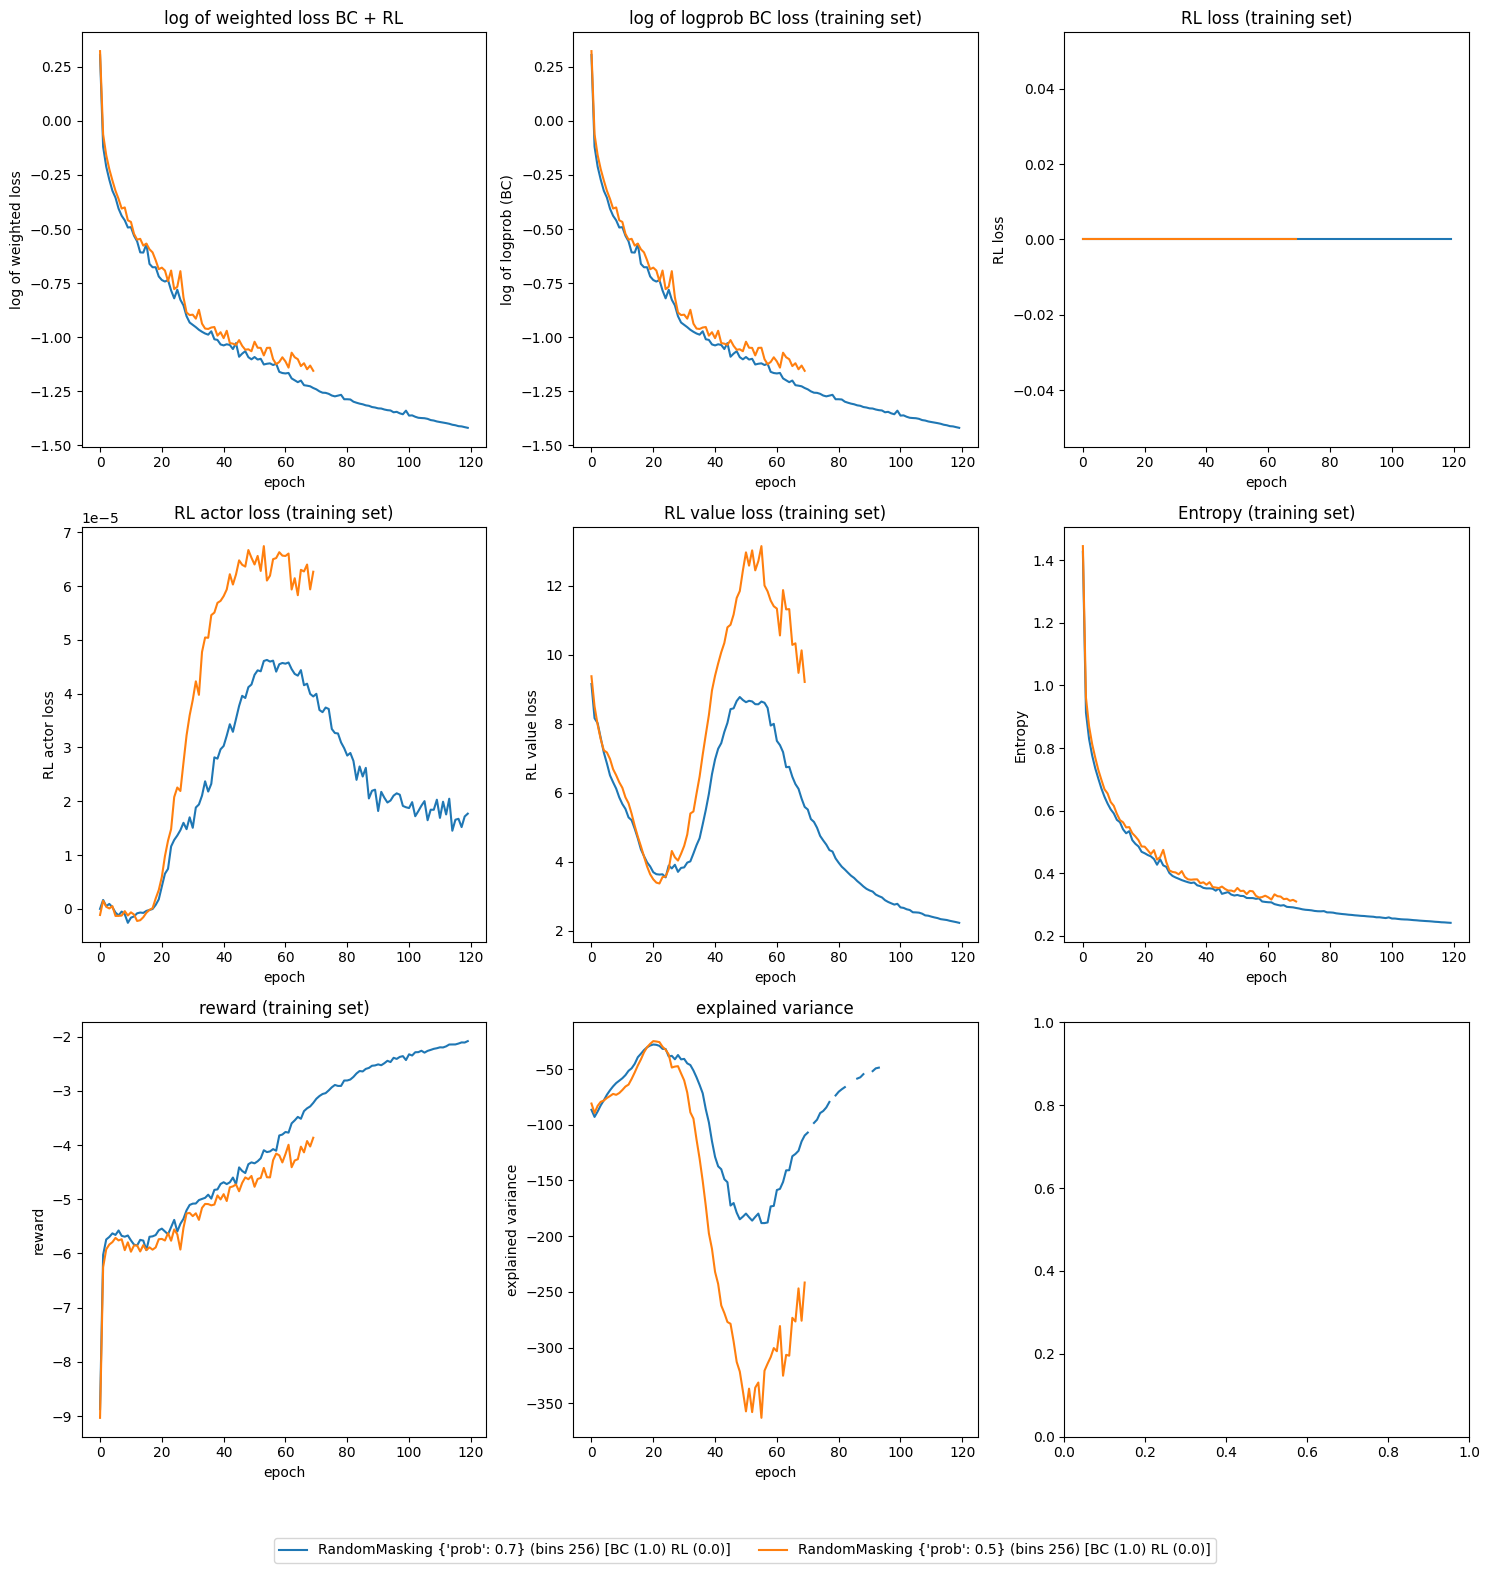

In [17]:
smooth = True
window_size = 1

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
labels = []

for ii, (X, losses) in enumerate(zip(X_list, losses_list)):
    config = config_list[ii]
    label = (
        f"Full obs {config['feature_extractor_kwargs']['keys']} (bins {config['bins']})"
        if "obs_mask_kwargs" not in config or config["obs_mask_kwargs"] is None
        else f"{config['obs_mask']} {jax.tree_map(lambda x: np.round(x, 2).item(), config['obs_mask_kwargs'])} (bins {config['bins']})"
    )

    label += f" [BC ({config['loss_weight_bc']}) RL ({config['loss_weight_rl']})]"

    labels.append(label)

    y_values = jnp.log(jnp.array(losses)) if config["discrete"] else jnp.array(losses)
    if smooth:
        y_values = np.convolve(
            y_values.squeeze(), np.ones(window_size) / window_size, mode="valid"
        )
    y_label = "log of weighted loss" if config["discrete"] else "weighted loss"
    title = (
        "log of weighted loss BC + RL"
        if config["discrete"]
        else "weighted loss (training set)"
    )

    axes[0, 0].plot(y_values, label=label)
    axes[0, 0].set_title(title)
    axes[0, 0].set_ylabel(y_label)
    axes[0, 0].set_xlabel("epoch")

if type != "":
    for ii, (X, bc_losses) in enumerate(zip(X_list, bc_losses_list)):
        config = config_list[ii]

        y_values = (
            jnp.log(jnp.array(bc_losses))
            if config["discrete"]
            else jnp.array(bc_losses)
        )
        if smooth:
            y_values = np.convolve(
                y_values.squeeze(), np.ones(window_size) / window_size, mode="valid"
            )
        y_label = (
            f"log of {config['loss']} (BC)" if config["discrete"] else config["loss"]
        )
        title = (
            f"log of {config['loss']} BC loss (training set)"
            if config["discrete"]
            else f"{config['loss']} loss (training set)"
        )

        axes[0, 1].plot(y_values, label=label)
        axes[0, 1].set_title(title)
        axes[0, 1].set_ylabel(y_label)
        axes[0, 1].set_xlabel("epoch")

    for ii, (X, rl_losses) in enumerate(zip(X_list, rl_losses_list)):
        config = config_list[ii]
        y_values = jnp.array(rl_losses)
        if smooth:
            y_values = np.convolve(
                y_values.squeeze(), np.ones(window_size) / window_size, mode="valid"
            )
        y_label = "RL loss"
        title = (
            "RL loss (training set)"
            if config["discrete"]
            else f"{config['loss']} loss (training set)"
        )

        axes[0, 2].plot(y_values, label=label)
        axes[0, 2].set_title(title)
        axes[0, 2].set_ylabel(y_label)
        axes[0, 2].set_xlabel("epoch")

    for ii, (X, actor_losses) in enumerate(zip(X_list, actor_losses_list)):
        config = config_list[ii]
        label = f"RL weight {config['loss_weight_rl']}"
        y_values = jnp.array(actor_losses)
        if smooth:
            y_values = np.convolve(
                y_values.squeeze(), np.ones(window_size) / window_size, mode="valid"
            )

        axes[1, 0].plot(y_values, label=label)
        axes[1, 0].set_title("RL actor loss (training set)")
        axes[1, 0].set_ylabel("RL actor loss")
        axes[1, 0].set_xlabel("epoch")

    for ii, (X, value_losses) in enumerate(zip(X_list, value_losses_list)):
        config = config_list[ii]
        label = f"RL weight {config['loss_weight_rl']}"
        y_values = jnp.array(value_losses)
        if smooth:
            y_values = np.convolve(
                y_values.squeeze(), np.ones(window_size) / window_size, mode="valid"
            )

        axes[1, 1].plot(y_values, label=label)
        axes[1, 1].set_title("RL value loss (training set)")
        axes[1, 1].set_ylabel("RL value loss")
        axes[1, 1].set_xlabel("epoch")

    for ii, (X, entropies) in enumerate(zip(X_list, entropies_list)):
        config = config_list[ii]
        y_values = jnp.array(entropies)
        if smooth:
            y_values = np.convolve(
                y_values.squeeze(), np.ones(window_size) / window_size, mode="valid"
            )

        axes[1, 2].plot(y_values, label=label)
        axes[1, 2].set_title("Entropy (training set)")
        axes[1, 2].set_ylabel("Entropy")
        axes[1, 2].set_xlabel("epoch")

    for ii, (X, rewards) in enumerate(zip(X_list, rewards_list)):
        config = config_list[ii]
        y_values = jnp.array(rewards)
        if smooth:
            y_values = np.convolve(
                y_values.squeeze(), np.ones(window_size) / window_size, mode="valid"
            )

        axes[2, 0].plot(y_values, label=label)
        axes[2, 0].set_title("reward (training set)")
        axes[2, 0].set_ylabel("reward")
        axes[2, 0].set_xlabel("epoch")

    for ii, (X, explained_variances) in enumerate(
        zip(X_list, explained_variances_list)
    ):
        y_values = jnp.array(explained_variances)
        if smooth:
            y_values = np.convolve(
                y_values.squeeze(), np.ones(window_size) / window_size, mode="valid"
            )

        axes[2, 1].plot(y_values, label=label)
        axes[2, 1].set_title("explained variance")
        axes[2, 1].set_ylabel("explained variance")
        axes[2, 1].set_xlabel("epoch")

# Create a shared legend for all plots
fig.legend(labels, loc="lower center", bbox_to_anchor=(0.5, -0.05), ncol=3)

plt.tight_layout()
plt.show()

In [9]:
X = np.arange(n_epochs)

log_div_list = []
overlap_list = []
offroad_list = []
val_loss_list = []

for ii, training_dict in enumerate(training_dict_list):
    log_div = []
    overlap = []
    offroad = []
    val_loss = []

    n_epochs = n_epochs_list[ii]

    for e in range(0, n_epochs, config["freq_eval"]):
        log_div.append(
            np.array(training_dict[e]["validation"]["log_divergence"]).mean()
        )
        overlap.append(np.array(training_dict[e]["validation"]["overlap"]).mean())
        offroad.append(np.array(training_dict[e]["validation"]["offroad"]).mean())
        if type != "":
            val_loss.append(np.array(training_dict[e]["validation"]["bc_loss"]).mean())
        else:
            val_loss.append(np.array(training_dict[e]["validation"]["loss"]).mean())

    log_div.append(
        np.array(training_dict[n_epochs]["validation"]["log_divergence"]).mean()
    )
    overlap.append(np.array(training_dict[n_epochs]["validation"]["overlap"]).mean())
    offroad.append(np.array(training_dict[n_epochs]["validation"]["offroad"]).mean())
    if type != "":
        val_loss.append(
            np.array(training_dict[n_epochs]["validation"]["bc_loss"]).mean()
        )
    else:
        val_loss.append(np.array(training_dict[n_epochs]["validation"]["loss"]).mean())

    log_div_list.append(log_div)
    overlap_list.append(overlap)
    offroad_list.append(offroad)
    val_loss_list.append(val_loss)

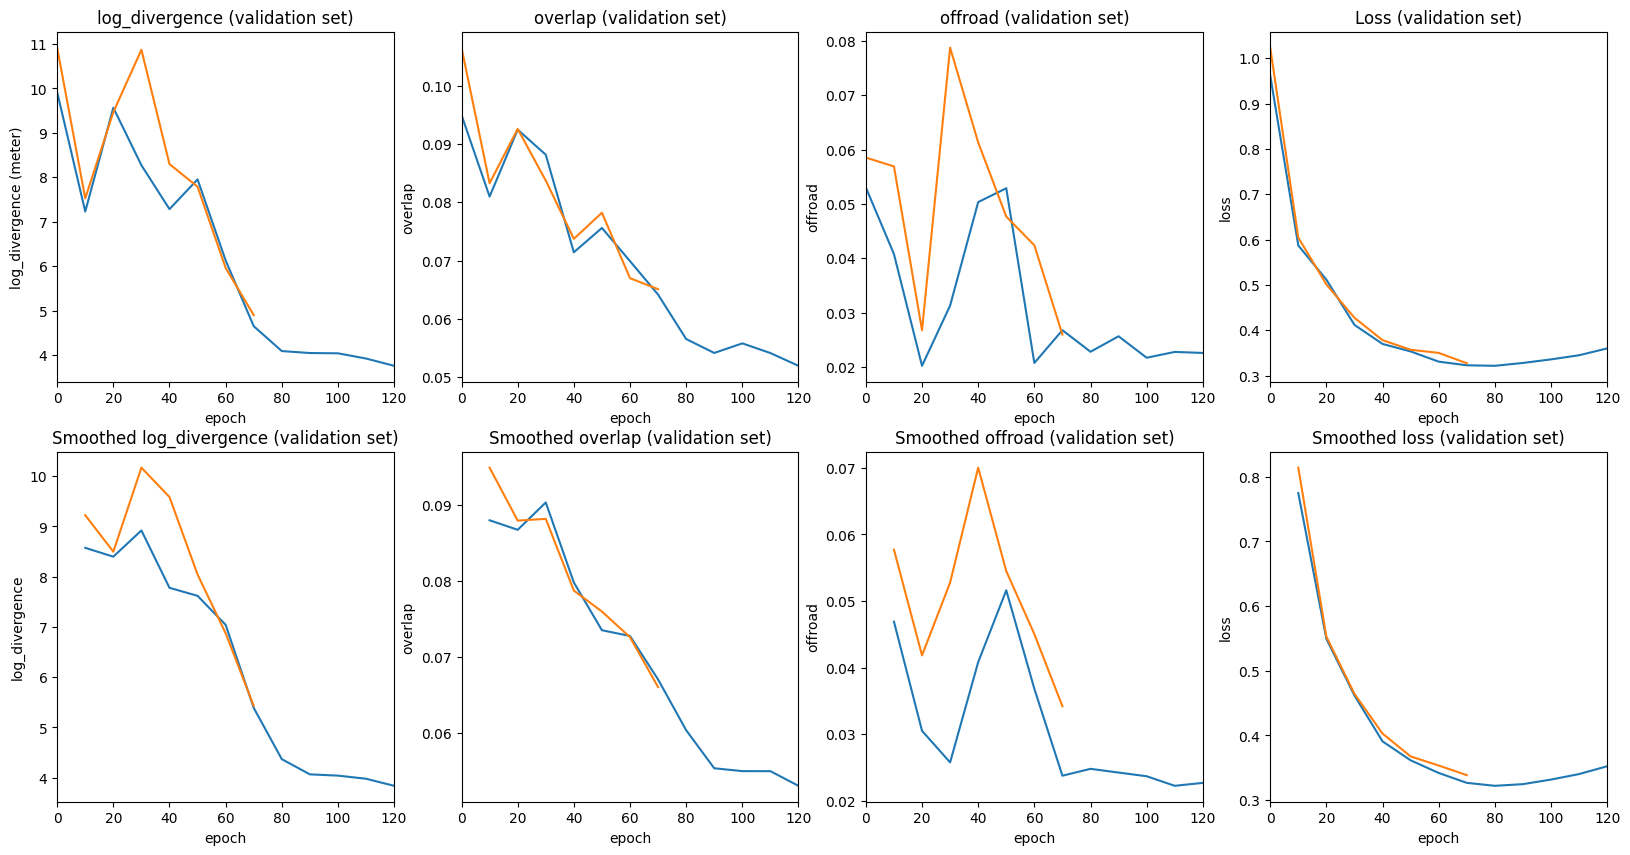

In [10]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))

for ii, _ in enumerate(n_epochs_list):
    X = X_list[ii]
    config = config_list[ii]
    n_epochs = n_epochs_list[ii]

    log_div = log_div_list[ii]
    overlap = overlap_list[ii]
    offroad = offroad_list[ii]
    loss = val_loss_list[ii]

    if "obs_mask_kwargs" not in config.keys() or config["obs_mask_kwargs"] is None:
        label = f"Full obs {config['feature_extractor_kwargs']['keys']}"
    else:
        label = f"{config['obs_mask']} {config['obs_mask_kwargs']}"

    X = np.arange((n_epochs // config["freq_eval"]) + 1) * config["freq_eval"]
    if n_epochs % 10 != 0:
        X = jnp.concatenate((X, jnp.array([n_epochs])))

    # fig.add_subplot(2,3,1)
    axes[0, 0].plot(X, log_div, label=label)
    axes[0, 0].set_title("log_divergence (validation set)")
    axes[0, 0].set_ylabel("log_divergence (meter)")
    axes[0, 0].set_xlabel("epoch")
    axes[0, 0].set_xlim(0, max(n_epochs_list))
    # fig.add_subplot(2,3,2)
    axes[0, 1].plot(X, overlap, label=label)
    axes[0, 1].set_title("overlap (validation set)")
    axes[0, 1].set_ylabel("overlap")
    axes[0, 1].set_xlabel("epoch")
    axes[0, 1].set_xlim(0, max(n_epochs_list))
    # fig.add_subplot(2,3,3)
    axes[0, 2].plot(X, offroad, label=label)
    axes[0, 2].set_title("offroad (validation set)")
    axes[0, 2].set_ylabel("offroad")
    axes[0, 2].set_xlabel("epoch")
    axes[0, 2].set_xlim(0, max(n_epochs_list))

    axes[0, 3].plot(X, loss, label=label)
    axes[0, 3].set_title("Loss (validation set)")
    axes[0, 3].set_ylabel("loss")
    axes[0, 3].set_xlabel("epoch")
    axes[0, 3].set_xlim(0, max(n_epochs_list))
    window_size = 2

    smoothed_log_div = np.convolve(
        log_div, np.ones(window_size) / window_size, mode="valid"
    )
    smoothed_overlap = np.convolve(
        overlap, np.ones(window_size) / window_size, mode="valid"
    )
    smoothed_offroad = np.convolve(
        offroad, np.ones(window_size) / window_size, mode="valid"
    )
    smoothed_loss = np.convolve(loss, np.ones(window_size) / window_size, mode="valid")

    # Plotting the smoothed curves

    axes[1, 0].plot(X[window_size - 1 :], smoothed_log_div)
    axes[1, 0].set_title("Smoothed log_divergence (validation set)")
    axes[1, 0].set_ylabel("log_divergence")
    axes[1, 0].set_xlabel("epoch")
    axes[1, 0].set_xlim(0, max(n_epochs_list))
    axes[1, 1].plot(X[window_size - 1 :], smoothed_overlap)
    axes[1, 1].set_title("Smoothed overlap (validation set)")
    axes[1, 1].set_ylabel("overlap")
    axes[1, 1].set_xlabel("epoch")
    axes[1, 1].set_xlim(0, max(n_epochs_list))
    axes[1, 2].plot(X[window_size - 1 :], smoothed_offroad)
    axes[1, 2].set_title("Smoothed offroad (validation set)")
    axes[1, 2].set_ylabel("offroad")
    axes[1, 2].set_xlabel("epoch")
    axes[1, 2].set_xlim(0, max(n_epochs_list))

    axes[1, 3].plot(X[window_size - 1 :], smoothed_loss)
    axes[1, 3].set_title("Smoothed loss (validation set)")
    axes[1, 3].set_ylabel("loss")
    axes[1, 3].set_xlabel("epoch")
    axes[1, 3].set_xlim(0, max(n_epochs_list))

# axes.legend()

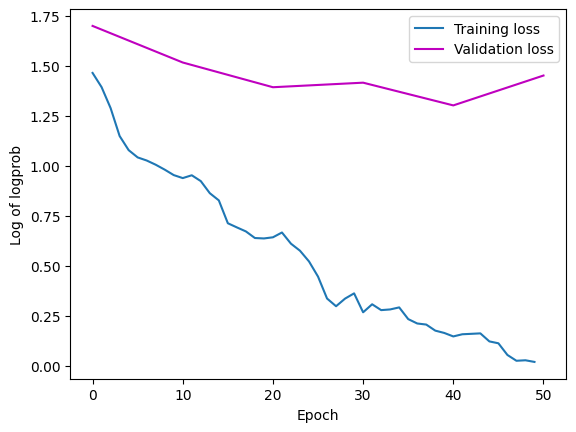

In [11]:
if config["discrete"]:
    plt.plot(jnp.log(jnp.array(losses)), label="Training loss")
    plt.plot(X, jnp.log(jnp.array(val_loss)), label="Validation loss", color="m")
    plt.ylabel(f"Log of {config['loss']}")
else:
    plt.plot(jnp.array(losses), label="Training loss")
    plt.plot(X, jnp.array(val_loss), label="Validation loss", color="m")
    plt.ylabel(f"{config['loss']}")

plt.xlabel("Epoch")
plt.legend()

In [16]:
from tabulate import tabulate

data = []
validation_dict = training_dict_list[0][199]["validation"]

for key, values in validation_dict.items():
    mean_value = np.array(values).mean()
    data.append([key, f"{mean_value:.4f}"])

# Print the table
print("Final metrics (validation set)\n")
print(tabulate(data, headers=["Metric", "Mean Value"], tablefmt="grid"))

Final metrics (validation set)

+--------------------+--------------+
| Metric             |   Mean Value |
+====================+==============+
| log_divergence     |       4.7917 |
+--------------------+--------------+
| max_log_divergence |      14.8107 |
+--------------------+--------------+
| overlap_rate       |       0.2937 |
+--------------------+--------------+
| overlap            |       0.0542 |
+--------------------+--------------+
| offroad_rate       |       0.1381 |
+--------------------+--------------+
| offroad            |       0.0135 |
+--------------------+--------------+
| bc_loss            |       0.343  |
+--------------------+--------------+
| mse                |       0.0006 |
+--------------------+--------------+


## Learned policy

In [18]:
import functools
import dataclasses
from IGDrivSim.utils import tf_examples_dataset, preprocess_serialized_womd_data

In [85]:
type = "_bc_rl"  # ''

load_folder = f"./logs{type}"
expe_num = "20240703_122753"

with open(os.path.join(load_folder, expe_num, "args.json"), "r") as file:
    config = json.load(file)

In [86]:
config["num_epochs"] = 1
config["num_envs_eval"] = 1

n_epochs = 199

print("Create datasets")

# Data iter config
WOD_1_1_0_VALIDATION = _config.DatasetConfig(
    path=config["validation_path"],
    max_num_rg_points=config["max_num_rg_points"],
    shuffle_seed=None,
    data_format=_config.DataFormat.TFRECORD,
    batch_dims=(config["num_envs_eval"],),
    max_num_objects=config["max_num_obj"],
    include_sdc_paths=config["include_sdc_paths"],
    repeat=1,
)

# Validation dataset
val_dataset = tf_examples_dataset(
    path=WOD_1_1_0_VALIDATION.path,
    data_format=WOD_1_1_0_VALIDATION.data_format,
    preprocess_fn=functools.partial(
        preprocess_serialized_womd_data, config=WOD_1_1_0_VALIDATION
    ),
    shuffle_seed=WOD_1_1_0_VALIDATION.shuffle_seed,
    shuffle_buffer_size=WOD_1_1_0_VALIDATION.shuffle_buffer_size,
    repeat=WOD_1_1_0_VALIDATION.repeat,
    batch_dims=WOD_1_1_0_VALIDATION.batch_dims,
    num_shards=WOD_1_1_0_VALIDATION.num_shards,
    deterministic=WOD_1_1_0_VALIDATION.deterministic,
    drop_remainder=WOD_1_1_0_VALIDATION.drop_remainder,
    filter_function=None,
    tf_data_service_address=WOD_1_1_0_VALIDATION.tf_data_service_address,
    batch_by_scenario=WOD_1_1_0_VALIDATION.batch_by_scenario,
)

env_config = _config.EnvironmentConfig(
    controlled_object=_config.ObjectType.SDC,
    max_num_objects=128,  # config['max_num_obj'],
)

with open(os.path.join(load_folder, expe_num, f"params_{n_epochs}.pkl"), "rb") as file:
    params = pickle.load(file)

Create datasets


In [87]:
id = 0
data_iter = val_dataset.as_numpy_iterator()
_post_process = functools.partial(
    dataloader.womd_factories.simulator_state_from_womd_dict,
    include_sdc_paths=config["include_sdc_paths"],
)

2024-07-09 15:50:55.175503: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [90]:
from utils.dataloader import tf_examples_dataset, inter_filter_funct, speed_filter_funct

data = next(data_iter)
scenario = _post_process(data)
id += 1

print("Validation scenario idx:", id)
print("Has SDC:", jnp.any(scenario.object_metadata.is_sdc))

_, sdc_idx = jax.lax.top_k(scenario.object_metadata.is_sdc, k=1)
sdc_mean_speed = jnp.take_along_axis(
    scenario.log_trajectory.speed, sdc_idx[..., None], axis=1
).mean()

print(
    "SDC mean speed:",
    sdc_mean_speed,
    f"(filtered {not speed_filter_funct(data, min_mean_speed=1)})",
)

Validation scenario idx: 3
Has SDC: True
SDC mean speed: 10.503763 (filtered False)


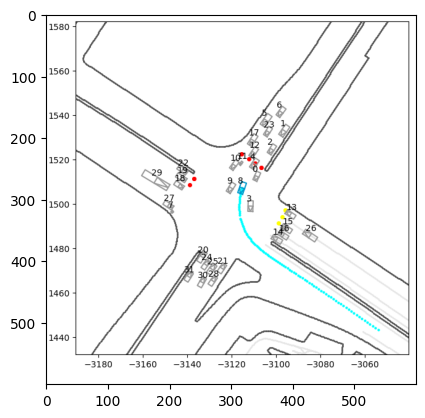

In [91]:
plt.imshow(plot_simulator_state(jax.tree_map(lambda x: x[0], scenario)))

In [92]:
from IGDrivSim.obs_mask import (
    SpeedConicObsMask,
    SpeedGaussianNoise,
    SpeedUniformNoise,
    ZeroMask,
)
from IGDrivSim.utils import DiscreteActionSpaceWrapper
import numpy as np

extractors = {"ExtractObs": ExtractObs}
feature_extractors = {"KeyExtractor": KeyExtractor}

obs_masks = {
    "ZeroMask": ZeroMask,
    "SpeedGaussianNoise": SpeedGaussianNoise,
    "SpeedUniformNoise": SpeedUniformNoise,
    "SpeedConicObsMask": SpeedConicObsMask,
}

if "dynamics" not in config.keys():
    config["dynamics"] = "bicycle"

if config["dynamics"] == "bicycle":
    wrapped_dynamics_model = dynamics.InvertibleBicycleModel()
elif config["dynamics"] == "delta":
    wrapped_dynamics_model = dynamics.DeltaLocal()
else:
    raise ValueError("Unknown dynamics")

if config["discrete"]:
    action_space_dim = wrapped_dynamics_model.action_spec().shape[0]
    wrapped_dynamics_model = DiscreteActionSpaceWrapper(
        dynamics_model=wrapped_dynamics_model,
        bins=config["bins"] * np.ones(action_space_dim, dtype=int),
    )
    config["num_components"] = None
    config["num_action"] = config["bins"] + 1
else:
    wrapped_dynamics_model = wrapped_dynamics_model
    config["num_components"] = 6
    config["num_action"] = None

dynamics_model = _env.PlanningAgentDynamics(wrapped_dynamics_model)

env = _env.PlanningAgentEnvironment(
    dynamics_model=wrapped_dynamics_model,
    config=env_config,
)

# DEFINE EXPERT AGENT
expert_agent = agents.create_expert_actor(dynamics_model)

# DEFINE EXTRACTOR AND FEATURE_EXTRACTOR
extractor = extractors[config["extractor"]](config)
feature_extractor = feature_extractors[config["feature_extractor"]]
feature_extractor_kwargs = config["feature_extractor_kwargs"]

# DEFINE OBSERVABILITY MASK
if "obs_mask" not in config.keys():
    config["obs_mask"] = None

if config["obs_mask"]:
    obs_mask = obs_masks[config["obs_mask"]](**config["obs_mask_kwargs"])
else:
    obs_mask = None

In [93]:
action_space_dim = wrapped_dynamics_model.action_spec().shape[0]

network = ActorCriticRNN(
    action_space_dim,
    dynamics_model.action_spec().minimum,
    dynamics_model.action_spec().maximum,
    feature_extractor_class=feature_extractor,
    feature_extractor_kwargs=feature_extractor_kwargs,
    discrete=config["discrete"],
    num_components=config["num_components"],
    num_action=config["num_action"],
)

feature_extractor_shape = feature_extractor_kwargs["final_hidden_layers"]

tx = optax.chain(
    optax.clip_by_global_norm(config["max_grad_norm"]),
    optax.adam(config["lr"], eps=1e-5),
)

train_state = TrainState.create(
    apply_fn=network.apply,
    params=params,
    tx=tx,
)

init_rnn_state_eval = ScannedRNN.initialize_carry(
    (config["num_envs_eval"], feature_extractor_shape)
)

In [94]:
from typing import NamedTuple


class Transition(NamedTuple):
    done: jnp.ndarray
    expert_action: jnp.array
    obs: jnp.ndarray


rng = jax.random.PRNGKey(42)
rng, rng_extract = jax.random.split(rng)

init_rnn_state_eval = ScannedRNN.initialize_carry(
    (config["num_envs_eval"], feature_extractor_shape)
)


def _log_step(cary, rng_extract):
    current_state, rng = cary

    done = current_state.is_done
    # Extract obs in SDC referential
    obs = datatypes.sdc_observation_from_state(
        current_state, roadgraph_top_k=config["roadgraph_top_k"]
    )

    # Mask
    rng, rng_obs = jax.random.split(rng)
    if obs_mask is not None:
        obs = obs_mask.mask_obs(current_state, obs, rng_obs)

    # Extract the features from the observation

    # rng, rng_extract = jax.random.split(rng)
    obsv = extractor(current_state, obs, rng_extract)

    transition = Transition(done, None, obsv)

    # Update the simulator state with the expert action
    expert_action = expert_agent.select_action(
        state=current_state, params=None, rng=None, actor_state=None
    )

    # Patch bug in waymax (squeeze timestep dimension when using reset --> need squeezed timestep for update)
    current_timestep = current_state["timestep"]
    # Squeeze timestep dim
    current_state = dataclasses.replace(current_state, timestep=current_timestep[0])

    current_state = env.step(current_state, expert_action.action)

    # Unsqueeze timestep dim
    current_state = dataclasses.replace(current_state, timestep=current_timestep + 1)

    return (current_state, rng), transition


def extand(x):
    if isinstance(x, jnp.ndarray):
        return x[:, jnp.newaxis, ...]
    else:
        return x

### Validation task

#### Context (10 first steps)

In [95]:
# Compute the rnn_state on first env.config.init_steps from the log trajectory
rng, rng_log = jax.random.split(rng)
(current_state, rng), log_traj_batch = jax.lax.scan(
    _log_step,
    (scenario, rng_log),
    rng_extract[None].repeat(env.config.init_steps - 1, axis=0),
    env.config.init_steps - 1,
)

rnn_state, _, _, weights, actor_mean, actor_std = network.apply(
    train_state.params,
    init_rnn_state_eval,
    (log_traj_batch.obs, log_traj_batch.done[:, jnp.newaxis, ...]),
)

In [69]:
def plot_gaussian(mean, std, ax):
    x = jnp.linspace(mean - 4 * std, mean + 4 * std, 1000)
    y = 1 / (std * jnp.sqrt(2 * jnp.pi)) * jnp.exp(-((x - mean) ** 2) / (2 * std**2))
    ax.plot(x, y, label=f"Mean: {mean}, Std: {std}")

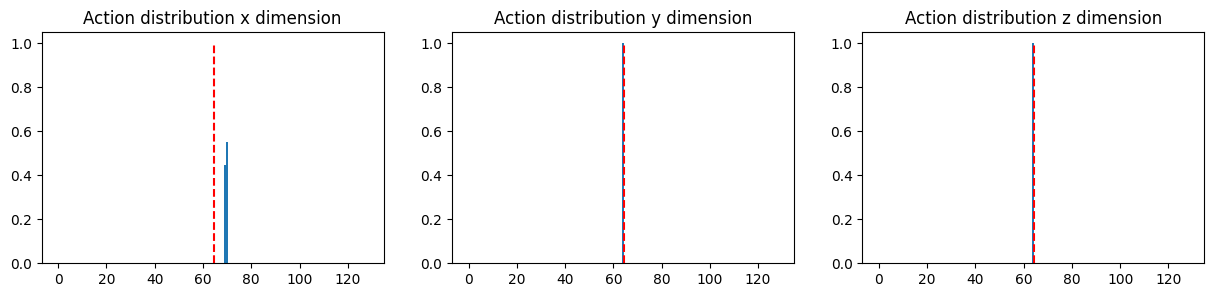

In [70]:
step = 7
means = actor_mean[step].squeeze()

if not config["discrete"]:
    stds = actor_std[step].squeeze()

    fig, axes = plt.subplots(
        ncols=wrapped_dynamics_model.action_spec().shape[0], nrows=1, figsize=(20, 5)
    )
    for i in range(6):
        plot_gaussian(means[0, i], stds[0, i], axes[0])
        plot_gaussian(means[1, i], stds[1, i], axes[1])
        # plot_gaussian(means[2, i], stds[2, i], axes[2])

    for i in range(wrapped_dynamics_model.action_spec().shape[0]):
        axes[i].set_xlim(
            dynamics_model.action_spec().minimum[i],
            dynamics_model.action_spec().maximum[i],
        )

else:
    logits = means
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 3))
    labels = ["x", "y", "z"]

    for i in range(action_space_dim):
        axes[i].bar(np.arange(config["bins"] + 1), jax.nn.softmax(logits[i]))
        axes[i].set_title(f"Action distribution {labels[i]} dimension")
        axes[i].plot(
            [(config["bins"] + 1) / 2, (config["bins"] + 1) / 2],
            [0, 1],
            ls="--",
            c="r",
            label="0 in continuous space",
        )

#### Prediction (80 steps)

In [96]:
ego_imgs = []
global_imgs = []
scenario_metrics = {"log_divergence": [], "overlap": [], "offroad": []}

mean_list = []
std_list = []
weight_list = []

action_list = []

step = 0
while not current_state.is_done:
    step += 1

    done = current_state.is_done

    # Extract obs in SDC referential
    obs = datatypes.sdc_observation_from_state(
        current_state, roadgraph_top_k=config["roadgraph_top_k"]
    )

    # Mask
    rng, rng_obs = jax.random.split(rng)
    if obs_mask is not None:
        obs = obs_mask.mask_obs(current_state, obs, rng_obs)

    # Extract the features from the observation
    # rng, rng_extract = jax.random.split(rng)
    obsv = extractor(current_state, obs, rng_extract)

    # Generate image

    reduced_sdc_obs = jax.tree_map(lambda x: x[0, ...], obs)  # Unbatch
    list_features = config["feature_extractor_kwargs"]["keys"]
    list_features = [
        item
        for feature in config["feature_extractor_kwargs"]["keys"]
        for item in (feature[1:-1].split(", ") if ("[" in feature) else [feature])
    ]

    if ("noisy_proxy_goal" in list_features) or ("proxy_goal" in list_features):
        if "proxy_goal" in list_features:
            goal = obsv["proxy_goal"][0]
        elif "noisy_proxy_goal" in list_features:
            goal = obsv["noisy_proxy_goal"][0]

        ego_img = plot_observation_with_goal(reduced_sdc_obs, obj_idx=0, goal=goal)

    elif "heading" in list_features:
        ego_img = plot_observation_with_heading(
            reduced_sdc_obs, obj_idx=0, heading=obsv["heading"].squeeze()
        )
    else:
        ego_img = visualization.plot_observation(
            jax.tree_map(lambda x: x[0], obs), obj_idx=0
        )

    global_img = plot_simulator_state(jax.tree_map(lambda x: x[0], current_state))

    # Sample action and update scenario
    rnn_state, action_dist, _, weights, actor_mean, actor_std = network.apply(
        train_state.params,
        rnn_state,
        (jax.tree_map(extand, obsv), done[jnp.newaxis, ...]),
    )
    rng, rng_sample = jax.random.split(rng)
    action_data = action_dist.sample(seed=rng_sample).squeeze(0)

    action_list.append(action_data)

    action = datatypes.Action(
        data=action_data, valid=jnp.ones((config["num_envs_eval"], 1), dtype="bool")
    )

    # Patch bug in waymax (squeeze timestep dimension when using reset --> need squeezed timestep for update)
    current_timestep = current_state["timestep"]
    # Squeeze timestep dim
    current_state = dataclasses.replace(current_state, timestep=current_timestep[0])

    current_state = env.step(current_state, action)

    # Unsqueeze timestep dim
    current_state = dataclasses.replace(current_state, timestep=current_timestep + 1)

    metric = env.metrics(current_state)
    ego_imgs.append(ego_img)
    global_imgs.append(global_img)

    for key, value in metric.items():
        if value.valid:
            scenario_metrics[key].append(value.value)

    mean_list.append(actor_mean)
    std_list.append(actor_std)
    weight_list.append(weights)

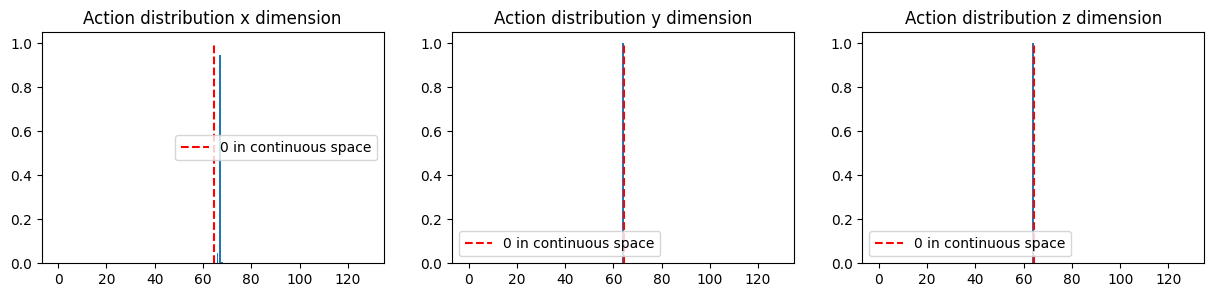

In [72]:
step = 10

means = mean_list[step].squeeze()

if not config["discrete"]:
    stds = actor_std[step].squeeze()

    fig, axes = plt.subplots(
        ncols=wrapped_dynamics_model.action_spec().shape[0], nrows=1, figsize=(20, 5)
    )
    for i in range(6):
        plot_gaussian(means[0, i], stds[0, i], axes[0])
        plot_gaussian(means[1, i], stds[1, i], axes[1])
        # plot_gaussian(means[2, i], stds[2, i], axes[2])

    for i in range(wrapped_dynamics_model.action_spec().shape[0]):
        axes[i].set_xlim(
            dynamics_model.action_spec().minimum[i],
            dynamics_model.action_spec().maximum[i],
        )

else:
    logits = means
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 3))
    labels = ["x", "y", "z"]

    for i in range(action_space_dim):
        axes[i].bar(np.arange(config["bins"] + 1), jax.nn.softmax(logits[i]))
        axes[i].set_title(f"Action distribution {labels[i]} dimension")
        axes[i].plot(
            [(config["bins"] + 1) / 2, (config["bins"] + 1) / 2],
            [0, 1],
            ls="--",
            c="r",
            label="0 in continuous space",
        )
        axes[i].legend()

In [31]:
print(f"Metrics on ex n_{id} of the validation dataset \n")
for key, value in scenario_metrics.items():
    print(f"{key}: {jnp.array(value).mean():0.4f} \n")

Metrics on ex n_1 of the validation dataset 

log_divergence: 4.4379 

overlap: 0.1875 

offroad: 0.0000 



##### Ego reference frame

In [32]:
mediapy.show_video(ego_imgs, fps=10)

In [38]:
# Save as gif
frames = []

for img in ego_imgs:
    pil_img = Image.fromarray(img)
    frames.append(pil_img)

save_animation_folder = "/data/tucana/cleain/imitation_gap_waymax/animation"

ex_saving_path = os.path.join(save_animation_folder, expe_num)
# os.mkdir(ex_saving_path)

# Save the frames as a GIF
frames[0].save(
    os.path.join(ex_saving_path, f"ex_{id}_ego.gif"),
    save_all=True,
    append_images=frames[1:],
    duration=100,
    loop=0,
)

##### Global reference frame

In [97]:
mediapy.show_video(global_imgs, fps=10)

In [ ]:
# Save as gif
frames = []

for img in ego_imgs:
    pil_img = Image.fromarray(img)
    frames.append(pil_img)

save_animation_folder = "/data/tucana/cleain/imitation_gap_waymax/animation"

ex_saving_path = os.path.join(save_animation_folder, expe_num)
# os.mkdir(ex_saving_path)

# Save the frames as a GIF
frames[0].save(
    os.path.join(ex_saving_path, f"ex_{id}_global.gif"),
    save_all=True,
    append_images=frames[1:],
    duration=100,
    loop=0,
)

### Training task

In [76]:
def _env_step(cary, rng_extract):
    current_state, rng = cary

    done = current_state.is_done

    # Extract obs in SDC referential
    obs = datatypes.sdc_observation_from_state(
        current_state, roadgraph_top_k=config["roadgraph_top_k"]
    )

    expert_action = expert_agent.select_action(
        state=current_state, params=None, rng=None, actor_state=None
    )

    # Mask
    rng, rng_obs = jax.random.split(rng)
    if obs_mask is not None:
        obs = obs_mask.mask_obs(current_state, obs, rng_obs)

    # Extract the features from the observation
    # rng, rng_extract = jax.random.split(rng)
    obsv = extractor(current_state, obs, rng_extract)
    # obsv['xyyaw'] = jnp.zeros_like(obsv['xyyaw'])

    transition = Transition(done, expert_action, obsv)

    ## UPDATING UNSING EXPERT ACTION IN THE ACTION SPACE
    expert_action = expert_agent.select_action(
        state=current_state, params=None, rng=None, actor_state=None
    )

    # Patch bug in waymax (squeeze timestep dimension when using reset --> need squeezed timestep for update)
    current_timestep = current_state["timestep"]
    # Squeeze timestep dim
    current_state = dataclasses.replace(current_state, timestep=current_timestep[0])

    current_state = env.step(current_state, expert_action.action)

    # Unsqueeze timestep dim
    current_state = dataclasses.replace(current_state, timestep=current_timestep + 1)

    # # UPDATING USING LOG (ALWAYS CONTINUOUS ACTION SPACE) /!\ when using discrete wrapper (distribution shift ++)
    # current_state = datatypes.update_state_by_log(current_state, num_steps=1)

    return (current_state, rng), transition

In [77]:
rng, rng_log = jax.random.split(rng)
(current_state, rng), log_traj_batch = jax.lax.scan(
    _log_step,
    (scenario, rng_log),
    rng_extract[None].repeat(env.config.init_steps - 1, axis=0),
    env.config.init_steps - 1,
)

# Use jax.lax.scan with the modified _env_step function
rng, rng_step = jax.random.split(rng)
(_, rng), traj_batch = jax.lax.scan(
    _env_step,
    (current_state, rng_step),
    rng_extract[None].repeat(config["num_steps"], axis=0),
    config["num_steps"],
)

In [78]:
# Compute the rnn_state from the log on the first steps
rnn_state, _, _, _, _, _ = network.apply(
    params, init_rnn_state_eval, (log_traj_batch.obs, log_traj_batch.done)
)
# Compute the action for the rest of the trajectory
_, action_dist, _, weights, actor_mean, actor_std = network.apply(
    params, rnn_state, (traj_batch.obs, traj_batch.done)
)

train_action = action_dist.sample(seed=rng)
expert_action = traj_batch.expert_action.action.data
mse = (
    wrapped_dynamics_model._discretizer.make_continuous(train_action)
    - wrapped_dynamics_model._discretizer.make_continuous(expert_action)
) ** 2

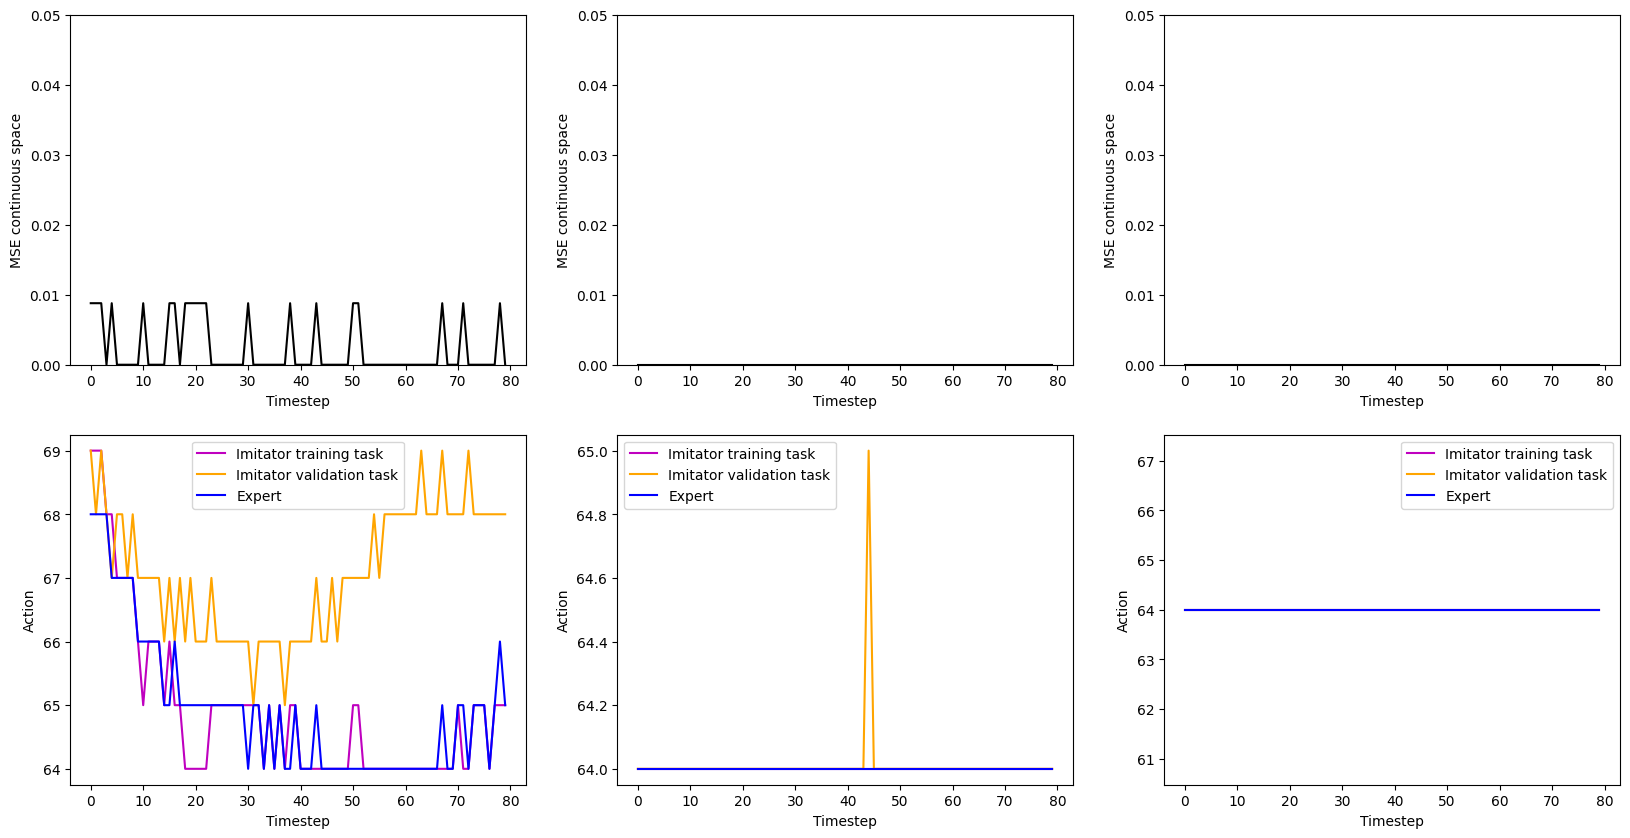

In [79]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))

val_action = jnp.array(action_list)

for i in range(3):
    axes[0, i].plot(mse[:, 0, i], c="k")
    axes[0, i].set_ylim(0, 0.05)
    axes[0, i].set_xlabel("Timestep")
    axes[0, i].set_ylabel("MSE continuous space")

    axes[1, i].set_xlabel("Timestep")
    axes[1, i].set_ylabel("Action")

    axes[1, i].plot(train_action[:, 0, i], label="Imitator training task", c="m")
    axes[1, i].plot(val_action[:, 0, i], label="Imitator validation task", c="orange")
    axes[1, i].plot(expert_action[:, 0, i], label="Expert", c="b")

    axes[1, i].legend()

## Ground truth (expert)

### Using continuous expert actions (i.e. log trajectory)

#### Global reference frame

In [22]:
current_state = scenario

imgs = []
for _ in range(90):
    current_state = datatypes.update_state_by_log(current_state, num_steps=1)
    imgs.append(plot_simulator_state(jax.tree_map(lambda x: x[0], current_state)))

mediapy.show_video(imgs, fps=10)

In [ ]:
# Save as gif
frames = []

for img in imgs:
    pil_img = Image.fromarray(img)
    frames.append(pil_img)

save_animation_folder = "/data/tucana/cleain/imitation_gap_waymax/animation"

ex_saving_path = os.path.join(save_animation_folder, expe_num)
os.mkdir(ex_saving_path)

# Save the frames as a GIF
frames[0].save(
    os.path.join(ex_saving_path, f"ex_{id}_GT_global_continuous.gif"),
    save_all=True,
    append_images=frames[1:],
    duration=100,
    loop=0,
)

#### Ego reference frame

In [15]:
current_state = scenario

imgs = []
for _ in range(90):
    current_state = datatypes.update_state_by_log(current_state, num_steps=1)

    obs = datatypes.sdc_observation_from_state(
        current_state, roadgraph_top_k=config["roadgraph_top_k"]
    )

    imgs.append(
        visualization.plot_observation(jax.tree_map(lambda x: x[0], obs), obj_idx=0)
    )

mediapy.show_video(imgs, fps=10)

### Using discretised expert actions

#### Global reference frame

In [23]:
current_state = scenario
scenario_metrics = {"log_divergence": [], "overlap": [], "offroad": []}

imgs = []
for _ in range(90):
    expert_action = expert_agent.select_action(
        state=current_state, params=None, rng=None, actor_state=None
    )

    # Patch bug in waymax (squeeze timestep dimension when using reset --> need squeezed timestep for update)
    current_timestep = current_state["timestep"]
    # Squeeze timestep dim
    current_state = dataclasses.replace(current_state, timestep=current_timestep[0])

    current_state = env.step(current_state, expert_action.action)

    # Unsqueeze timestep dim
    current_state = dataclasses.replace(current_state, timestep=current_timestep + 1)

    imgs.append(plot_simulator_state(jax.tree_map(lambda x: x[0], current_state)))

    metric = env.metrics(current_state)

    for key, value in metric.items():
        if value.valid:
            scenario_metrics[key].append(value.value)

mediapy.show_video(imgs, fps=10)

In [24]:
print(
    f"Metrics on ex n_{id} of the validation dataset between the discrete and the continuous expert \n"
)
for key, value in scenario_metrics.items():
    print(f"{key}: {jnp.array(value).mean():0.4f} \n")

Metrics on ex n_3 of the validation dataset between the discrete and the continuous expert 

log_divergence: 0.0355 

overlap: 0.0000 

offroad: 0.0000 



In [35]:
_, sdc_idx = jax.lax.top_k(current_state.object_metadata.is_sdc, k=1)
sim_sdc_xy = jnp.take_along_axis(
    current_state.sim_trajectory.xy, sdc_idx[None, None, ...], axis=1
).squeeze()
log_sdc_xy = jnp.take_along_axis(
    current_state.log_trajectory.xy, sdc_idx[None, None, ...], axis=1
).squeeze()

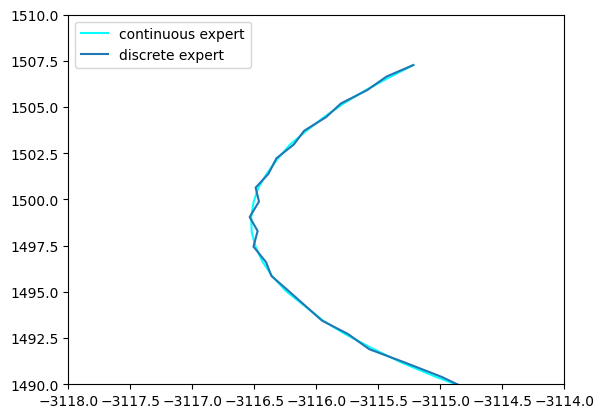

In [48]:
plt.plot(log_sdc_xy[:, 0], log_sdc_xy[:, 1], c="cyan", label="continuous expert")
plt.plot(sim_sdc_xy[:, 0], sim_sdc_xy[:, 1], label="discrete expert")
plt.ylim(1490, 1510)
plt.xlim(-3118, -3114)
plt.legend()

#### Ego reference frame

In [24]:
current_state = scenario

imgs = []
for _ in range(90):
    obs = datatypes.sdc_observation_from_state(
        current_state, roadgraph_top_k=config["roadgraph_top_k"]
    )

    expert_action = expert_agent.select_action(
        state=current_state, params=None, rng=None, actor_state=None
    )

    # Patch bug in waymax (squeeze timestep dimension when using reset --> need squeezed timestep for update)
    current_timestep = current_state["timestep"]
    # Squeeze timestep dim
    current_state = dataclasses.replace(current_state, timestep=current_timestep[0])

    current_state = env.step(current_state, expert_action.action)

    # Unsqueeze timestep dim
    current_state = dataclasses.replace(current_state, timestep=current_timestep + 1)

    imgs.append(
        visualization.plot_observation(jax.tree_map(lambda x: x[0], obs), obj_idx=0)
    )

mediapy.show_video(imgs, fps=10)